## Quickly inspect some posterior samples for a model

In [65]:
# two moons model, using the MCMC implementation of the Exc-SSM authors
import numpy as np
# posterior_samples = np.load('exchange_mcmc_trace2.npy')
# posterior_samples = np.load('results/two_moons_1000/Exc-SSM/100_inn_steps/exchange_mcmc_trace1.npy')

task = "slcp"
posterior_samples = np.load(f'results/{task}/Exc-SSM/100_inn_steps/exchange_mcmc_trace1.npy')
# posterior_samples = np.load(f'results/{task}/Exc-SSM/100_inn_steps/exchange_mcmc_trace2.npy')

In [67]:
import torch
from sbibm.visualisation import fig_posterior

fig_posterior(
    task,
    num_observation=1,
    samples_tensor=torch.from_numpy(posterior_samples)
)

/Users/pierreglaser/.local/miniforge/envs/sbibm-smnle/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

## Analyze Exc-SSM grid search results

In [131]:
with open('results_all.pkl', 'rb') as f:
    import pickle
    results = pickle.load(f)

In [132]:
import pandas as pd
result = dict(results)

In [163]:
df = pd.concat({k: pd.DataFrame(v) for k, v in result.items()}, names=("task", "num_observation", "lr", "num_samples")).applymap(lambda x: x.item()).reset_index(-1, drop=True)
df.index = df.index.set_names("num_simulations",level="num_samples")
df.index = df.index.set_levels(["10³", "10⁴", "10⁵"] ,level="num_simulations")

In [164]:
avg_results = df.groupby(["task", "num_simulations"])

In [165]:
df

c2st       mmd
task           num_observation lr    num_simulations                   
lotka_volterra 1               0.010 10³              0.99970  0.248750
                                     10⁴              0.99995  0.603069
                                     10⁵              0.99965  0.368977
                               0.005 10³              0.99965  0.134018
                                     10⁴              0.99980  0.641779
...                                                       ...       ...
slcp           10              0.005 10⁴              0.96135  0.105706
                                     10⁵              0.98810  0.297777
                               0.001 10³              0.97860  0.309153
                                     10⁴              0.95545  0.104830
                                     10⁵              0.94775  0.080911

[360 rows x 2 columns]

In [166]:
new_gs = []
for n, g in avg_results:
    mean_per_lr = g.mmd.groupby(level="lr").mean()
    best_lr = mean_per_lr.index[mean_per_lr.argmin()]
    new_g = g.xs(best_lr, level="lr", drop_level=False)
    new_gs.append(new_g)
    
best_results = pd.concat(new_gs)

In [167]:
best_results_mean = best_results.groupby(["task", "num_simulations"]).mean()
best_results_std = best_results.groupby(["task", "num_simulations"]).mean()

In [168]:
best_results = best_results.rename(columns={"c2st": "C2ST", "mmd": "MMD"})

In [169]:
# metric = "C2ST"
# task = "two_moons"
# best_results.xs(task, level="task").groupby("num_samples")[metric]

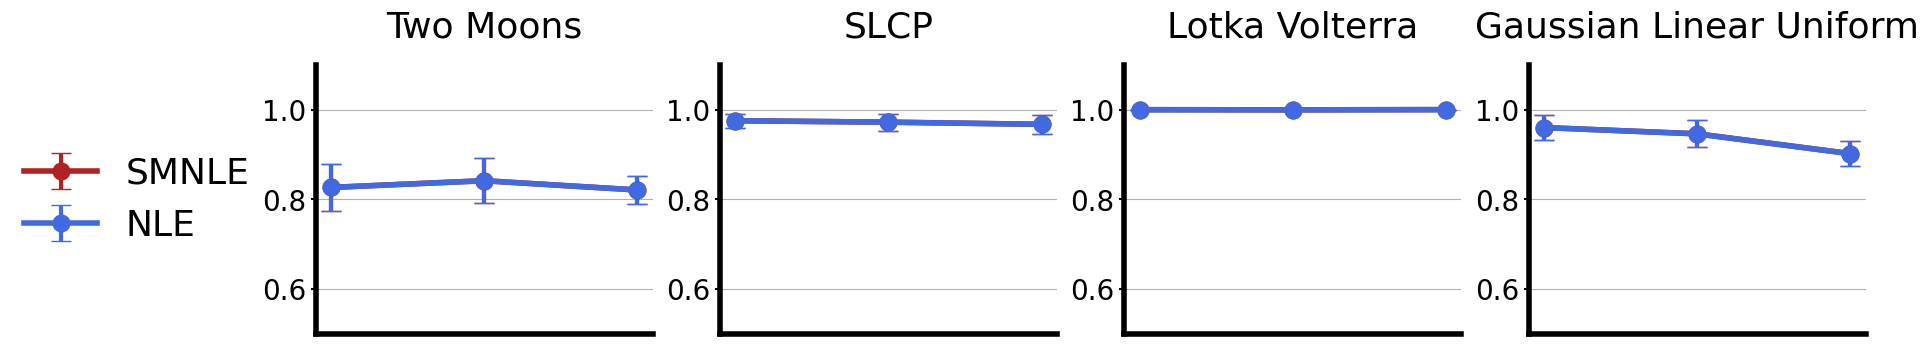

In [173]:
import matplotlib as mpl
import matplotlib.pyplot as plt

pretty_names = {
    "two_moons": "Two Moons",
    "slcp": "SLCP",
    "gaussian_linear_uniform": "Gaussian Linear Uniform",
    "lotka_volterra": "Lotka Volterra"
}
metric = "C2ST"
limits_metric = {
    "MMD": (0, 1),
    "C2ST": (0.5, 1.1)
}

errorbar_kws = dict(
    linewidth=4,
    elinewidth=3,
    markersize=12,
    capsize=7, 
    marker="o"
)

ar = best_results


fontsize=26
tk_fontsize=20

with mpl.rc_context(fname='.matplotlibrc'):
    mpl.rc('font',family='DejaVu Sans')
    mpl.rc("text", usetex=False)
    
    # ax.plot(
    #     "-+",
    # )
    tasks = ("two_moons", "slcp", "lotka_volterra", "gaussian_linear_uniform")
    nrows = 1
    f, axss = plt.subplots(ncols=len(tasks), nrows=nrows, figsize=(5 * len(tasks), 3.5 * nrows))
    
    if nrows > 1:
        axs = axss[0]
    else:
        axs = axss
    for t_no, task in enumerate(tasks):
        ax = axs[t_no]
        ax.grid(axis="y")
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(4)
            
        ax.errorbar(
            ar.xs(task, level="task").groupby("num_simulations")[metric].mean().index,
            ar.xs(task, level="task").groupby("num_simulations")[metric].mean(),
            ar.xs(task, level="task").groupby("num_simulations")[metric].std(),
            label="SMNLE",
            color="firebrick",
            **errorbar_kws
        )
        ax.set_ylim(*limits_metric[metric])

        ax.errorbar(
            ar.xs(task, level="task").groupby("num_simulations")[metric].mean().index,
            ar.xs(task, level="task").groupby("num_simulations")[metric].mean(),
            ar.xs(task, level="task").groupby("num_simulations")[metric].std(),
            label="NLE",
            color="royalblue",
            **errorbar_kws
        )

        ax.set_title(pretty_names[task], fontsize=fontsize, pad=20)
        ax.tick_params(axis='both', labelsize=tk_fontsize)
        ax.get_xaxis().set_ticks([])

        
    l = axs[0].legend(fontsize=fontsize, bbox_to_anchor=(-0.1, 0.5), bbox_transform=axs[0].transAxes, loc="center right")
    l.texts[0].set_weight("bold")
    
    l = axs[0].legend(fontsize=fontsize, bbox_to_anchor=(-0.1, 0.5), bbox_transform=axs[0].transAxes, loc="center right")
    # l.texts[0].set_weight("bold")
        
    # plt.errorbar(x, y + 3, yerr=yerr, label='both limits (default)')
    

    # ax.legend(fontsize=18)
    # 
    # ax.set_ylabel("Energy. Distance", fontsize=14)
    # ax.set_xlabel("Round No.", fontsize=14)
f